# Comparing packet behavior while streaming from YouTube at different resolutions

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import glob
import re

In [55]:
# Load in files
frames = []
for fp in glob.glob('../data/unzipped/*p-*novpn*.csv'):
    df = pd.read_csv(fp)
    df['quality'] = int(re.findall(r"(\d{3,4})p", fp)[0])
    # Trim all to exactly 5 minutes
    df = df[df.Time <= df.Time.min() + 5*60]
    frames.append(df)
    
# Join into a single table
raw = pd.concat(frames).sort_values(['quality', 'Time'])
raw['Time'] = pd.to_datetime(raw['Time'], unit='s')

In [56]:
# Let's clean up this data

# I'm not really interested in other local IPs that are communicating with my
# computer, like printers and other computers on the network.
#
#! Hold on -- might actually want these?
both_local = (
    (raw.IP1.str.startswith('10.0.0.'))
    & (raw.IP2.str.startswith('10.0.0.') | (raw.IP2.str.startswith('192.168.')))
)

# I also want to get rid of local multicasting, this is where IP1 is local and
# IP2 is in the 224-239 range
# See: http://www.tcpipguide.com/free/t_IPMulticastAddressing.htm
#
#! Hold on -- might actually want these?
multicast = (
    (raw.IP1.str.startswith('10.0.0.')
    & (
        raw.IP2.str.split('.')
        .apply(lambda lst: 224 <= int(lst[0]) <= 239))
    )
)

# And ignore broadcasts to 255.*
broadcast = (raw.IP2.str.startswith('255'))

# And ignore the 

udp = (raw.Proto == 17)
tcp = (raw.Proto == 6)

# I know that this IP is from Firefox doing tab syncs, I can safely ignore it
firefox_sync = (raw.IP2 == '54.149.94.178')

# We can find some outliers (super big spikes) and see what are data looks like
# without them
zscores = raw[['1->2Bytes','2->1Bytes','1->2Pkts','2->1Pkts']].transform(lambda x: (x - x.mean()) / x.std())
outliers = lambda deviations: (zscores.max(axis=1) > deviations)

data = raw[
#     ~both_local
#     & ~multicast
#     & ~broadcast
    ~firefox_sync
]
data.sample(10)

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs,quality
80,2020-10-26 19:31:29,10.0.0.233,54262,255.255.255.255,10001,17,154,0,1,0,1603740689649;,154;,1;,480
155,2020-10-26 17:40:29,10.0.0.236,36322,54.203.112.76,443,6,52,52,1,1,1603734029727;1603734029727;,52;52;,2;1;,1080
500,2020-10-26 19:35:03,10.0.0.233,54376,255.255.255.255,10001,17,154,0,1,0,1603740903147;,154;,1;,480
161,2020-10-26 19:24:51,10.0.0.1,0,224.0.0.1,0,2,28,0,1,0,1603740291209;,28;,1;,720
27,2020-10-26 19:23:41,10.0.0.100,10101,239.255.255.251,10101,17,64,0,1,0,1603740221580;,64;,1;,720
314,2020-10-26 19:40:09,10.0.0.113,60000,10.0.0.236,57111,17,387,0,1,0,1603741209295;,387;,1;,360
56,2020-10-26 19:43:58,10.0.0.113,60000,10.0.0.91,45435,17,387,0,1,0,1603741438626;,387;,1;,240
48,2020-10-26 19:31:08,10.0.0.192,64677,239.255.255.250,1900,17,202,0,1,0,1603740668824;,202;,1;,480
127,2020-10-26 19:24:29,10.0.0.233,54037,255.255.255.255,10001,17,154,0,1,0,1603740269501;,154;,1;,720
248,2020-10-26 19:39:38,10.0.0.233,54523,255.255.255.255,10001,17,154,0,1,0,1603741178706;,154;,1;,360


In [57]:
data.IP1.unique()

array(['10.0.0.217', '10.0.0.100', '10.0.0.86', '10.0.0.91', '10.0.0.233',
       '10.0.0.64', '10.0.0.255', '10.0.0.37', '10.0.0.230', '10.0.0.66',
       '10.0.0.173', '10.0.0.236', '10.0.0.190', '10.0.0.113',
       '10.0.0.32', '10.0.0.78', '10.0.0.105', '10.0.0.1', '10.0.0.252',
       '10.0.0.192', '10.0.0.65', '1.0.0.10'], dtype=object)

In [58]:
data.IP2.unique()

array(['224.0.1.60', '239.255.255.251', '233.89.188.1', '239.255.3.22',
       '10.0.0.236', '35.186.224.47', '255.255.255.255', '224.0.0.251',
       '239.255.255.250', '10.0.0.91', '10.0.0.66', '192.168.49.1',
       '75.75.75.75', '35.190.245.236', '52.209.204.108', '35.224.99.156',
       '224.0.0.1', '224.168.168.168', '224.0.0.2', '34.242.70.15',
       '224.0.0.252', '44.236.195.29', '64.4.54.254', '152.199.4.33',
       '52.48.84.254', '35.222.85.5', '35.165.119.189', '52.26.8.232',
       '35.186.227.140', '52.48.132.232', '10.0.0.255', '52.250.30.213',
       '52.250.42.157', '34.253.97.22', '34.199.85.193', '10.0.0.32',
       '54.203.112.76', '3.215.209.232', '54.228.140.0', '34.197.186.26',
       '15.222.169.74', '3.96.231.136', '13.107.13.93', '104.42.78.153',
       '13.86.218.248', '104.154.127.57', '13.35.121.89', '52.32.34.32',
       '54.70.109.38'], dtype=object)

In [59]:
quals = data.groupby('quality')

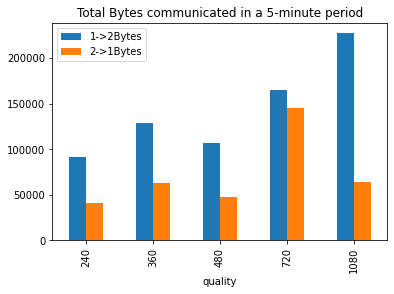

In [60]:
# Total bytes communicated in *exactly* a 5 minute period
total_bytes = quals[['1->2Bytes','2->1Bytes']].agg(np.sum)
total_bytes.plot(kind='bar')
plt.title('Total Bytes communicated in a 5-minute period');

In [61]:
# Trend in 1->2Bytes -- why would we be transferring more data? Should it be the
# other way around?

Text(0.5, 1.0, 'Total Packets communicated in a 5-minute period')

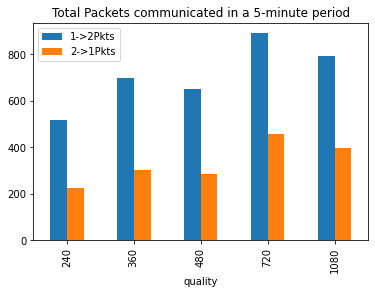

In [62]:
total_packets = quals[['1->2Pkts','2->1Pkts']].agg(np.sum)
total_packets.plot(kind='bar')
plt.title('Total Packets communicated in a 5-minute period')

In [63]:
# Lots of the packets are TCP, so our computer needs to send an ACK frequently,
# but I would have never expected our computer to be sending so freaking much
# data.

Text(0.5, 1.0, 'Total Bytes - Only TCP communications')

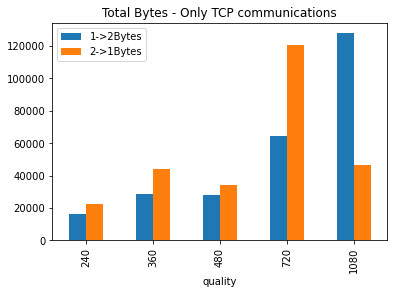

In [64]:
# Filtering to just TCP
(
    raw[tcp & ~firefox_sync]
    .groupby('quality')[['1->2Bytes','2->1Bytes']]
    .agg(np.sum)
    .plot(kind='bar')
)
plt.title('Total Bytes - Only TCP communications')

Text(0.5, 1.0, 'Total Bytes - Only TCP & Outliers (spikes) removed')

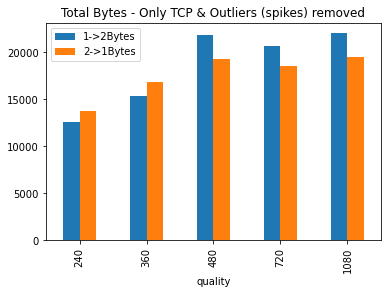

In [65]:
# Huh! So ACKs aren't to blame... and I think there are some 720 and 1080
# spikes that I'll try removing
(
    raw[tcp & ~outliers(5) & ~firefox_sync]
    # Only TCP and removes rows with Bytes or Pkts measurements that are >n stds
    # away from the mean in their respective quality groups.
    .groupby('quality')[['1->2Bytes','2->1Bytes']]
    .agg(np.sum)
    .plot(kind='bar')
)
plt.title('Total Bytes - Only TCP & Outliers (spikes) removed')

In [66]:
# No more drastic changes between resolution groups.

#! This is *very* sensitive to changing the outliers cutoff because the sum is
#  very sensitive to outliers... This viz produces what looks like a convincing
#  trend as resolution increases -- but it needs more evidence to confirm it.

Text(0.5, 1.0, 'Median Bytes - Only TCP')

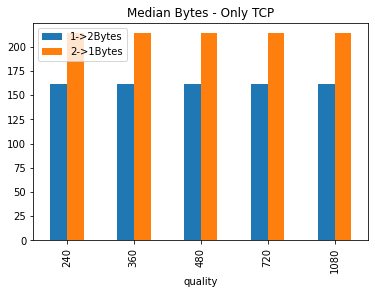

In [67]:
# Worth noting that if we stop looking at the total and look instead at some
# non-outlier prone aggregation like median communication, everything looks the
# same
(
    raw[tcp & ~firefox_sync]
    .groupby('quality')[['1->2Bytes','2->1Bytes']]
    .agg(np.median)
    .plot(kind='bar')
)
plt.title('Median Bytes - Only TCP')

In [68]:
# No matter the resolution, there must be some IP to which
# the traffic is *exactly* the same.

#! A question for future exploration is: **does this consistent traffic appear
#  only when streaming?**

In [69]:
# I have a bunch of questions now:
# - What traffic is using UDP? Whatever it is must be sending lots of bytes...
#   Is it relevant to streaming at all?
# - Evidently, there must be a lot of traffic with the exact same number of
#   bytes sent/received in order for the qualities to have exactly equal medians
#   This points to consistent traffic that's being communicated regardless of
#   resolution... can I find it?

Text(0.5, 1.0, 'Total Bytes - UDP Only')

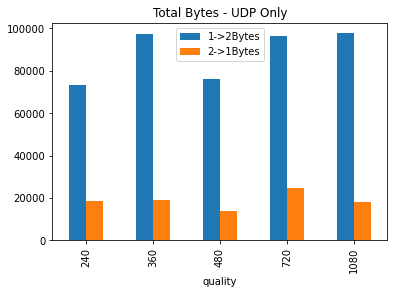

In [70]:
# Let's attempt to tackle the UDP question
(
    raw[udp]
    .groupby('quality')[['1->2Bytes','2->1Bytes']]
    .agg(np.sum)
    .plot(kind='bar')
)
plt.title('Total Bytes - UDP Only')

In [71]:
# Again, all pretty similar -- definitely no clear trends between resolutions.
# But, we do have a lot of bytes sent

Text(0.5, 1.0, 'Total Bytes - ')

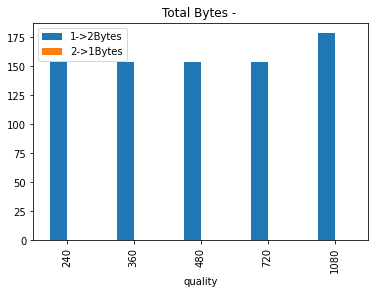

In [72]:
(
    raw[udp & ~firefox_sync]
    .groupby('quality')[['1->2Bytes','2->1Bytes']]
    .agg(np.median)
    .plot(kind='bar')
)
plt.title('Total Bytes - ')

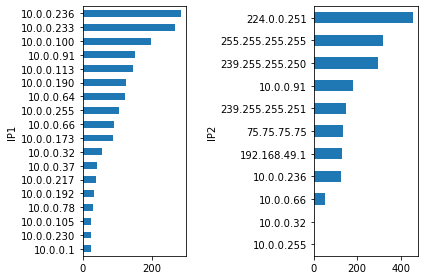

In [73]:
# Most of the UDP communications aren't receiving data, but sending...

# What are these communications?
fig,(ax1,ax2) = plt.subplots(1,2)
raw[udp].groupby('IP1')['Time'].count().sort_values().plot.barh(ax=ax1)
raw[udp].groupby('IP2')['Time'].count().sort_values().plot.barh(ax=ax2)
plt.tight_layout()

In [74]:
# They look like they're all local communications --
# - 10.xx are devices
# - 192.168.xx is also private... not sure what it is
# - 224-239.xx are multicast communications **Do these have any relevance to
#   streaming externally?
# - 255.xx is a broadcast communication
# - 75.75.75.75 is my ISP, Comcast
#
# And these are **all** of the UDP communications -- nothing is external
# (besides comcast)...
#
# Now, the domain expert question is -- does purely local communication have
# anything to do with what activity a single device is performing? Is it worth
# hanging on to this data, or should it be filtered out?

In [75]:
# Let's find what that consistent TCP traffic is
d = raw[tcp & ~firefox_sync]
d[d["1->2Bytes"] == d["1->2Bytes"].median()]

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs,quality
4,2020-10-26 19:43:44,10.0.0.100,8009,10.0.0.236,44458,6,162,214,1,2,1603741424987;1603741424992;1603741424992;,162;162;52;,2;1;2;,240
18,2020-10-26 19:43:50,10.0.0.100,8009,10.0.0.236,44458,6,162,52,1,1,1603741430000;1603741430000;,162;52;,1;2;,240
32,2020-10-26 19:43:55,10.0.0.100,8009,10.0.0.236,44458,6,162,214,1,2,1603741435001;1603741435006;1603741435006;,162;162;52;,2;1;2;,240
67,2020-10-26 19:44:00,10.0.0.100,8009,10.0.0.236,44458,6,162,214,1,2,1603741440008;1603741440012;1603741440012;,162;162;52;,2;1;2;,240
74,2020-10-26 19:44:05,10.0.0.100,8009,10.0.0.236,44458,6,162,214,1,2,1603741445014;1603741445020;1603741445020;,162;162;52;,2;1;2;,240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,2020-10-26 17:43:45,10.0.0.100,8009,10.0.0.91,44484,6,162,214,1,2,1603734225050;1603734225056;1603734225056;,162;162;52;,2;1;2;,1080
514,2020-10-26 17:43:50,10.0.0.100,8009,10.0.0.91,44484,6,162,214,1,2,1603734230056;1603734230061;1603734230061;,162;162;52;,2;1;2;,1080
545,2020-10-26 17:43:55,10.0.0.100,8009,10.0.0.91,44484,6,162,214,1,2,1603734235062;1603734235067;1603734235067;,162;162;52;,2;1;2;,1080
554,2020-10-26 17:44:00,10.0.0.100,8009,10.0.0.91,44484,6,162,214,1,2,1603734240068;1603734240074;1603734240074;,162;162;52;,2;1;2;,1080


Text(0.5, 1.0, 'Total Bytes - TCP Only & Outliers removed & Local removed')

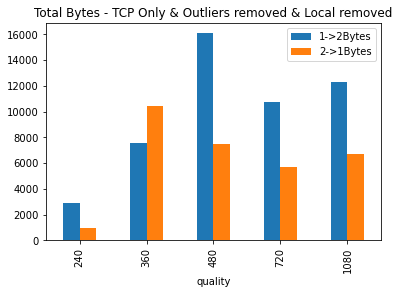

In [76]:
# Huh, *another* instance of local communication.
#
# How do our vizualizations change if I remove local communication?
(
    raw[tcp & ~firefox_sync & ~both_local & ~outliers(6)]
    .groupby('quality')[['1->2Bytes','2->1Bytes']]
    .agg(np.sum)
    .plot(kind='bar')
)
plt.title('Total Bytes - TCP Only & Outliers removed & Local removed')

Text(0.5, 1.0, 'Amazon Prime Total Bytes')

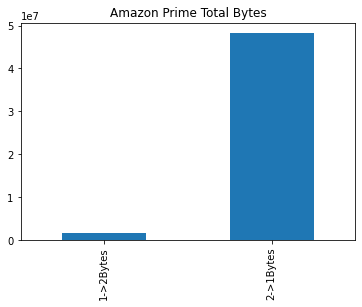

In [83]:
prime = pd.read_csv('../data/unzipped/pgaddiso-amazonprime-1x-novpn-linux-clean-20201019.csv')
prime = prime[prime.Time <= prime.Time + 5*60]
prime['Time'] = pd.to_datetime(prime['Time'], unit='s')
prime[['1->2Bytes','2->1Bytes']].agg(np.sum).plot.bar()
plt.title('Amazon Prime Total Bytes')

In [84]:
# A quick comparison to Amazon Prime shows that there's a lot more data received
# than sent -- which is expected.

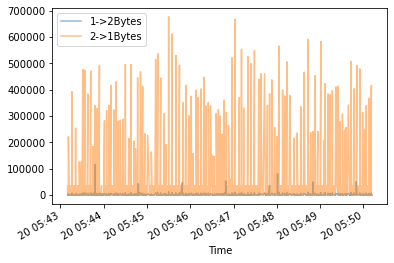

In [88]:
prime[['Time', '1->2Bytes', '2->1Bytes']].plot(x='Time', alpha=0.5)

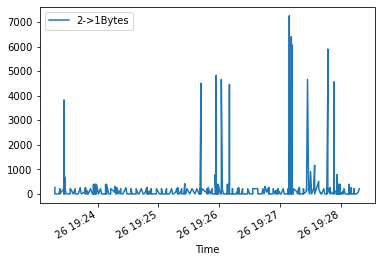

In [79]:
# Why is 720 bigger?
# Maybe I accidentally caught the initial buffer
data[data.quality == 720].plot(kind='line', x='Time', y='2->1Bytes') # Try 1->2Bytes

In [16]:
# Strange, there's just a huge spike

In [17]:
data.loc[data['1->2Bytes'].idxmax()]

Time                                                   1603740538
IP1                                                    10.0.0.236
Port1                                                       36136
IP2                                                35.186.227.140
Port2                                                         443
Proto                                                           6
1->2Bytes                                                   99762
2->1Bytes                                                   21513
1->2Pkts                                                       95
2->1Pkts                                                      102
packet_times    1603740538102;1603740538147;1603740538147;1603...
packet_sizes    60;60;52;715;52;52;264;52;116;222;780;632;52;8...
packet_dirs     1;2;1;1;2;2;2;1;1;1;1;2;1;1;2;2;1;2;2;1;2;1;2;...
quality                                                       720
Name: 685, dtype: object

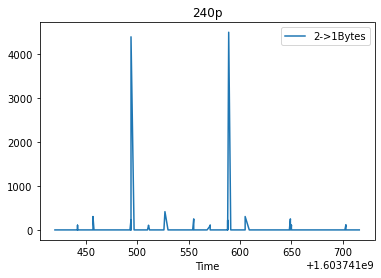

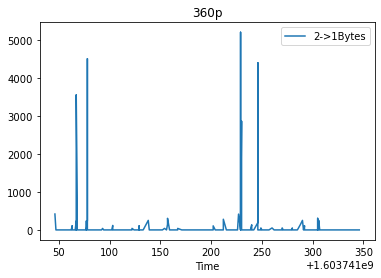

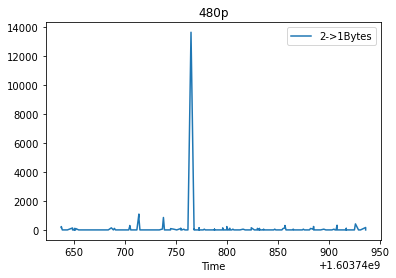

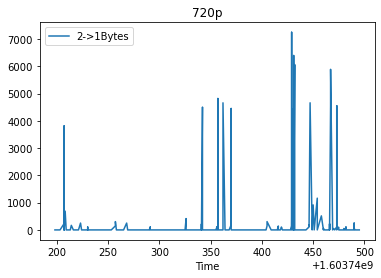

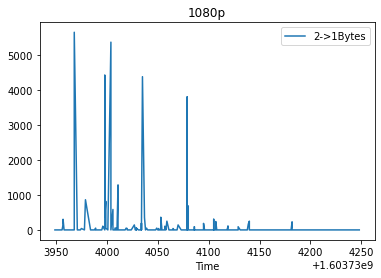

In [29]:
# Plot out 
def plot_bytes_over_time(df):
    p = df.groupby('quality')[[
        'Time',
#         '1->2Bytes',
        '2->1Bytes',
    ]].plot(x='Time',legend=True)
    
    for qual in p.keys():
        p[qual].title.set_text(f"{qual}p")
        
plot_bytes_over_time(raw[~firefox_sync & ~both_local])

In [ ]:
# Looks like the *spikes* are considerably more extreme as resolution goes up,
# but average number of bytes increases only slightly

In [207]:
# There's nothing reliable we can learn from those spikes -- let's just clean them out.
zscores = quals['1->2Bytes'].transform(lambda x: (x - x.mean()) / x.std())
data[zscores > 5]

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs,quality
523,1603741731,10.0.0.236,36218,35.186.227.140,443,6,4068,4885,22,24,1603741731222;1603741731242;1603741731242;1603...,60;60;52;715;52;264;52;116;222;780;632;52;83;5...,1;2;1;1;2;2;1;1;1;1;2;1;1;2;2;1;2;2;1;2;1;2;1;...,240
524,1603741731,10.0.0.236,38060,35.165.119.189,443,6,2404,4432,9,7,1603741731227;1603741731262;1603741731262;1603...,60;60;52;569;52;1500;52;2032;52;178;1337;52;10...,1;2;1;1;2;2;1;2;1;1;1;2;2;1;2;1;,240
184,1603741142,10.0.0.190,60000,239.255.255.250,1900,17,4353,0,12,0,1603741142434;1603741142434;1603741142435;1603...,337;346;383;385;337;346;383;385;337;346;383;385;,1;1;1;1;1;1;1;1;1;1;1;1;,360
346,1603741229,10.0.0.236,36192,35.186.227.140,443,6,3048,2232,15,12,1603741229736;1603741229757;1603741229757;1603...,60;60;52;715;52;264;52;116;222;779;52;632;52;8...,1;2;1;1;2;2;1;1;1;1;2;2;1;1;2;1;2;2;1;2;1;2;1;...,360
347,1603741229,10.0.0.113,60000,239.255.255.250,1900,17,2910,0,8,0,1603741229922;1603741229928;1603741229933;1603...,337;346;383;385;339;348;385;387;,1;1;1;1;1;1;1;1;,360
349,1603741230,10.0.0.113,60000,239.255.255.250,1900,17,5820,0,16,0,1603741230111;1603741230114;1603741230115;1603...,337;346;383;385;339;348;385;387;337;346;383;38...,1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;,360
125,1603740714,10.0.0.236,41476,34.199.85.193,443,6,3982,1093,13,9,1603740714523;1603740714606;1603740714606;1603...,60;60;52;610;52;198;52;103;229;52;130;52;90;50...,1;2;1;1;2;2;1;1;1;2;2;1;1;1;1;1;2;2;2;1;2;1;,480
234,1603740765,10.0.0.236,52382,3.215.209.232,443,6,2134,13627,15,11,1603740765515;1603740765601;1603740765601;1603...,60;60;52;614;52;198;52;103;229;264;358;52;130;...,1;2;1;1;2;2;1;1;1;1;1;2;2;1;1;2;1;2;1;2;1;2;1;...,480
506,1603740907,10.0.0.64,5353,224.0.0.251,5353,17,1918,0,7,0,1603740907069;1603740907381;1603740907484;1603...,277;277;393;202;277;131;361;,1;1;1;1;1;1;1;,480
507,1603740907,10.0.0.113,59892,239.255.255.250,1900,17,1778,0,3,0,1603740907323;1603740907324;1603740907324;,549;632;597;,1;1;1;,480


quality
240     AxesSubplot(0.125,0.125;0.775x0.755)
360     AxesSubplot(0.125,0.125;0.775x0.755)
480     AxesSubplot(0.125,0.125;0.775x0.755)
720     AxesSubplot(0.125,0.125;0.775x0.755)
1080    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

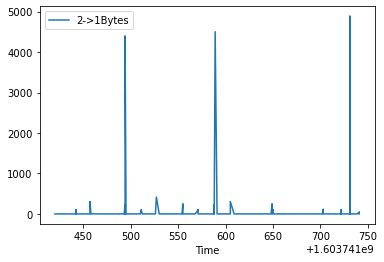

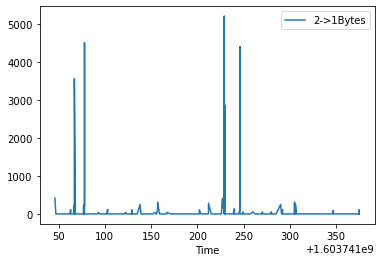

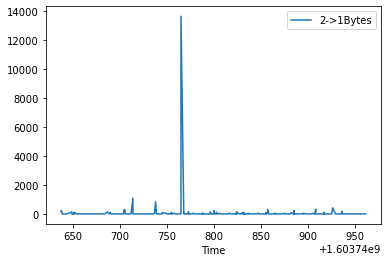

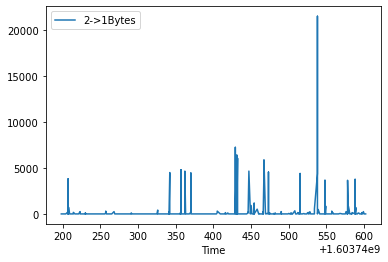

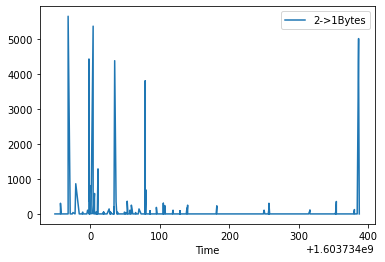

In [208]:
quals[['Time','2->1Bytes']].plot(x='Time')

## <font color="red">Worth mentioning: it looks like those *consistent* spikes aren't coming from an external ip -- maybe they're from a multicast or something? When I look at only external ips I don't get the same consistent spikes that other people see

### Some per-packet exploration (extended output)

In [11]:
per_packet = lambda string: [int(s) for s in string.strip(';').split(';')]

def per_packet_stats(group):
    # The sum is just appending all the lists
    packets = np.array(
        group
        .apply(per_packet)
        .sum()
    )
    return packets.min(), packets.mean(), np.median(packets), packets.max(), packets.sum(), len(packets)

In [12]:
pps = quals['packet_sizes'].agg(per_packet_stats)
pps

quality
240     (28, 184.2803738317757, 154.0, 3444, 157744, 856)
360     (28, 187.91002811621368, 154.0, 3480, 200500, ...
480              (28, 169.336, 140.5, 5844, 169336, 1000)
720     (28, 255.7121513944223, 105.0, 3819, 513470, 2...
1080    (28, 229.63815384615384, 153.0, 3480, 373162, ...
Name: packet_sizes, dtype: object

In [13]:
pps[720]

(28, 255.7121513944223, 105.0, 3819, 513470, 2008)

In [209]:
# I should at least look at the packet timing, I don't think anyone's looked at
# that yet

## Packet timing

In [210]:
data.filter(like='packet_').applymap(per_packet)

,packet_times,packet_sizes,packet_dirs
0,[1603741420701],[32],[1]
1,[1603741422183],[64],[1]
2,[1603741423622],[32],[1]
3,[1603741424976],[32],[1]
5,"[1603741425048, 1603741425381]","[87, 52]","[1, 1]"
...,...,...,...
829,[1603734384518],[89],[1]
830,[1603734384637],[407],[1]
832,"[1603734386204, 1603734386219, 1603734386219, ...","[60, 60, 52, 715, 52, 264, 52, 116, 222, 778, ...","[1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, ..."
833,"[1603734386204, 1603734386240, 1603734386240, ...","[60, 60, 52, 569, 52, 1500, 52, 2032, 52, 178,...","[1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1]"


In [211]:
# Maybe we can come up with a figure for data flow -- MB/s

# Why are the 1->2Bytes so large? I gue

## My bytes received is low -- true for VPN too?

In [98]:
# If we look at VPN case, does 2->1Bytes make more sense?
v = pd.read_csv('../data/unzipped/pgaddiso-youtube-1x-1080p-vpn-linux-clean-20201026a.csv')
v = v[v.Time <= v.Time + 5*60]
v['Time'] = pd.to_datetime(v['Time'], unit='s')
v[['1->2Bytes', '2->1Bytes']] = v[['1->2Bytes', '2->1Bytes']]

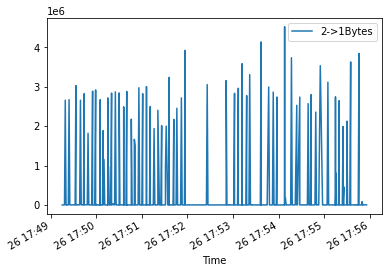

In [99]:
v.plot(x='Time', y='2->1Bytes')

In [91]:
# Sure enough, looks right for VPN.